This notebook is a follw-up of the has_pnemonia_classifier.ipynb which is designed to classify if a person has pnemonia. In this notebook, we try to classify the type of illness. But we need to explore the relative statistics to determine what is the underlying cause/illness.

Load Tensorflow

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import random
import os
from glob import glob
from PIL import Image
import pathlib
from typing import Dict

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import utils
from tensorflow.keras import Model

batch_size = 32

TensorFlow version: 2.6.0


Load helper functions and get the data

In [2]:
from src.datareader import get_metadata, get_summary_data
from src.find_images_without_metadata import find_images_without_metadata
from src.labelenums import Label2

metadata: pd.DataFrame = get_metadata()
metadata = metadata.loc[metadata['Label'] == 'Pnemonia']

In the above cell, we only include pnemonia patients.

In [3]:
summarydata: pd.DataFrame = get_summary_data()
print(summarydata)

      Label Label_2_Virus_category Label_1_Virus_category  Image_Count
0    Normal                                                       1576
1  Pnemonia         Stress-Smoking                   ARDS            2
2  Pnemonia                  Virus                                1493
3  Pnemonia                  Virus               COVID-19           58
4  Pnemonia                  Virus                   SARS            4
5  Pnemonia               bacteria                                2772
6  Pnemonia               bacteria          Streptococcus            5


We can already see that COVID-19 and SARS are under-represented in the dataset. With the knowledge that the virus that causes COVID-19 is also called SARS-CoV-19, indicating that they can be grouped together.

So let's consider three classification classes for our mocdel:
 1. BACTERIA --> Label 0
 2. VIRUS-NON-SARS --> Label 0.5
 3. VIRUS-SARS -- Label 1
 

Let's proceed to 

 1. Replace label names
 2. Separate between training and testing
 
Also let's take note that if we compare the counts of the training set and the summary data, we see that __THERE ARE NO SARS PATIENTS IN THE TEST/VALIDATION SET__. I will take 2/3 of the training sample of COVID-19 images and move them to the test sample

In [4]:
# Re-categorize the input labels
virus_non_sars_df = metadata.loc[(metadata['Label_1_Virus_category'] == 'Virus') & (metadata['Label_2_Virus_category'] == '')].copy()
virus_sars_df = metadata.loc[(metadata['Label_1_Virus_category'] == 'Virus') & ((metadata['Label_2_Virus_category'] == 'COVID-19') | (metadata['Label_2_Virus_category'] == 'SARS'))].copy()
bacteria_df = metadata.loc[(metadata['Label_1_Virus_category'] == 'bacteria')].copy()

# These labels are no longer needed
_, _, _ = virus_non_sars_df.pop('Label_2_Virus_category'), virus_sars_df.pop('Label_2_Virus_category'), bacteria_df.pop('Label_2_Virus_category')

In [5]:
# Use the new labels
virus_non_sars_df.replace('Virus', 'VIRUS-NON-SARS', inplace=True)
virus_sars_df.replace('Virus', 'VIRUS-SARS', inplace=True)
bacteria_df.replace('bacteria', 'BACTERIA', inplace=True)

# Split the COVID-19 images into 2/3 train and 1/3 test
virus_sars_train_df = virus_sars_df.iloc[0:int(0.667 * len(virus_sars_df))].copy()
virus_sars_test_df = virus_sars_df.iloc[int(0.667 * len(virus_sars_df))+1:].copy()
virus_sars_test_df.replace('Dataset_type', 'TEST', inplace=True)

In [6]:
# Re-create the metadata
relabelled_metadata_df = virus_non_sars_df.copy()
relabelled_metadata_df = relabelled_metadata_df.append(bacteria_df.copy())

# Create the training sample DataFrame
train_sample = relabelled_metadata_df.loc[metadata['Dataset_type'] == 'TRAIN']
train_sample = train_sample.append(virus_sars_train_df)

# Create the testing sample DataFrame
test_sample = relabelled_metadata_df.loc[metadata['Dataset_type'] == 'TEST']
test_sample = test_sample.append(virus_sars_test_df)

train_path = os.path.join(os.getcwd(), 'dataset', 'TRAIN')
test_path = os.path.join(os.getcwd(), 'dataset', 'TEST')

Let's examine the statistics of the training set

In [7]:
pivot_table = train_sample.pivot_table(columns=['Label_1_Virus_category'], aggfunc='size')
num_classes = int(np.unique(len(pivot_table)))
pivot_table

Label_1_Virus_category
BACTERIA          2535
VIRUS-NON-SARS    1345
VIRUS-SARS          41
dtype: int64

With the previous model, we tried to classify if someone was sick with pneumonia. This time, we want to categorize the type of illness with the patient's X-ray image.

In [8]:
new_size = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
diagnosis_labeler: Dict[str, int] = {
    'BACTERIA': 0,
    'VIRUS-NON-SARS': 1,
    'VIRUS-SARS': 2
}


def get_train_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = train_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label_1_Virus_category'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = diagnosis_labeler[label_str]
    return label_int


def get_test_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = test_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label_1_Virus_category'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = diagnosis_labeler[label_str]
    return label_int


def process_path(file_path, label):
    img1 = tf.io.read_file(file_path)
    img2 = tf.io.decode_png(img1, channels=1)
    img3 = tf.image.resize(img2, new_size, method='lanczos3', antialias=True)
    img4 = normalization_layer(img3)
    return img4, label


In [9]:
train_image_paths = [os.path.join(train_path, x) for x in list(train_sample['X_ray_image_name'])]

test_image_paths = [
    os.path.join(test_path, x) for x in list(test_sample['X_ray_image_name'])
    if os.path.isfile(os.path.join(test_path, x))
]
test_image_paths = np.append(test_image_paths, [
    os.path.join(train_path, x) for x in list(test_sample['X_ray_image_name'])
    if os.path.isfile(os.path.join(train_path, x))
])

train_labels = np.array([get_train_label(x) for x in train_image_paths], dtype=int)
test_labels = np.array([get_test_label(x) for x in test_image_paths], dtype=int)

Let's verify that each tain/test image has a label

In [10]:
for index in range(len(train_labels)):
    print(list(train_sample['X_ray_image_name'])[index], train_labels[index])

person101_virus_188.jpeg 1
person101_virus_187.jpeg 1
person1019_virus_1708.jpeg 1
person1019_virus_1707.jpeg 1
person1018_virus_1706.jpeg 1
person1016_virus_1704.jpeg 1
person1015_virus_1702.jpeg 1
person1015_virus_1701.jpeg 1
person1010_virus_1695.jpeg 1
person100_virus_184.jpeg 1
person1009_virus_1694.jpeg 1
person1008_virus_1691.jpeg 1
person1007_virus_1690.jpeg 1
person1005_virus_1688.jpeg 1
person1004_virus_1686.jpeg 1
person1003_virus_1685.jpeg 1
person1000_virus_1681.jpeg 1
person1159_virus_1944.jpeg 1
person1158_virus_1943.jpeg 1
person1158_virus_1942.jpeg 1
person1158_virus_1941.jpeg 1
person1158_virus_1940.jpeg 1
person1158_virus_1938.jpeg 1
person1157_virus_1937.jpeg 1
person1156_virus_1936.jpeg 1
person1156_virus_1935.jpeg 1
person1155_virus_1934.jpeg 1
person1154_virus_1933.jpeg 1
person1153_virus_1932.jpeg 1
person1152_virus_1930.jpeg 1
person1151_virus_1928.jpeg 1
person114_virus_217.jpeg 1
person1149_virus_1925.jpeg 1
person1149_virus_1924.jpeg 1
person1147_virus_1920.

person1501_virus_2611.jpeg 1
person1500_virus_2610.jpeg 1
person149_virus_299.jpeg 1
person1499_virus_2609.jpeg 1
person1497_virus_2607.jpeg 1
person1496_virus_2606.jpeg 1
person1496_virus_2605.jpeg 1
person1495_virus_2603.jpeg 1
person1494_virus_2601.jpeg 1
person1492_virus_2599.jpeg 1
person1491_virus_2597.jpeg 1
person1490_virus_2596.jpeg 1
person148_virus_298.jpeg 1
person1489_virus_2594.jpeg 1
person1488_virus_2593.jpeg 1
person1488_virus_2592.jpeg 1
person1488_virus_2589.jpeg 1
person1488_virus_2587.jpeg 1
person1488_virus_2585.jpeg 1
person1486_virus_2580.jpeg 1
person1484_virus_2577.jpeg 1
person1484_virus_2576.jpeg 1
person1483_virus_2574.jpeg 1
person1482_virus_2573.jpeg 1
person1482_virus_2572.jpeg 1
person1482_virus_2571.jpeg 1
person1482_virus_2570.jpeg 1
person1482_virus_2569.jpeg 1
person1481_virus_2567.jpeg 1
person1480_virus_2566.jpeg 1
person147_virus_297.jpeg 1
person1477_virus_2561.jpeg 1
person1476_virus_2560.jpeg 1
person1475_virus_2558.jpeg 1
person1474_virus_255

person510_virus_1026.jpeg 1
person509_virus_1025.jpeg 1
person509_virus_1024.jpeg 1
person508_virus_1021.jpeg 1
person508_virus_1020.jpeg 1
person507_virus_1019.jpeg 1
person506_virus_1018.jpeg 1
person505_virus_1017.jpeg 1
person503_virus_1013.jpeg 1
person502_virus_1012.jpeg 1
person502_virus_1011.jpeg 1
person501_virus_1010.jpeg 1
person500_virus_1009.jpeg 1
person499_virus_1008.jpeg 1
person498_virus_1007.jpeg 1
person497_virus_1005.jpeg 1
person496_virus_1003.jpeg 1
person495_virus_1001.jpeg 1
person494_virus_1000.jpeg 1
person493_virus_999.jpeg 1
person492_virus_998.jpeg 1
person491_virus_997.jpeg 1
person490_virus_996.jpeg 1
person489_virus_995.jpeg 1
person489_virus_994.jpeg 1
person488_virus_992.jpeg 1
person487_virus_991.jpeg 1
person486_virus_990.jpeg 1
person485_virus_988.jpeg 1
person484_virus_986.jpeg 1
person483_virus_985.jpeg 1
person482_virus_984.jpeg 1
person481_virus_983.jpeg 1
person480_virus_982.jpeg 1
person480_virus_981.jpeg 1
person479_virus_978.jpeg 1
person478

person891_virus_1541.jpeg 1
person890_virus_1540.jpeg 1
person88_virus_167.jpeg 1
person88_virus_166.jpeg 1
person88_virus_165.jpeg 1
person88_virus_164.jpeg 1
person1019_bacteria_2950.jpeg 0
person1018_bacteria_2949.jpeg 0
person1017_bacteria_2948.jpeg 0
person1016_bacteria_2947.jpeg 0
person1014_bacteria_2945.jpeg 0
person1012_bacteria_2943.jpeg 0
person1011_bacteria_2942.jpeg 0
person1010_bacteria_2941.jpeg 0
person1008_bacteria_2939.jpeg 0
person1007_bacteria_2938.jpeg 0
person1006_bacteria_2937.jpeg 0
person1005_bacteria_2936.jpeg 0
person1004_bacteria_2935.jpeg 0
person1003_bacteria_2934.jpeg 0
person1002_bacteria_2933.jpeg 0
person1001_bacteria_2932.jpeg 0
person1000_bacteria_2931.jpeg 0
person1159_bacteria_3104.jpeg 0
person1158_bacteria_3103.jpeg 0
person1157_bacteria_3102.jpeg 0
person1156_bacteria_3101.jpeg 0
person1155_bacteria_3100.jpeg 0
person1154_bacteria_3099.jpeg 0
person1150_bacteria_3095.jpeg 0
person1149_bacteria_3094.jpeg 0
person1146_bacteria_3091.jpeg 0
person11

person13_bacteria_50.jpeg 0
person13_bacteria_49.jpeg 0
person1399_bacteria_3549.jpeg 0
person1398_bacteria_3548.jpeg 0
person1396_bacteria_3545.jpeg 0
person1395_bacteria_3544.jpeg 0
person1392_bacteria_3538.jpeg 0
person1391_bacteria_3537.jpeg 0
person1391_bacteria_3536.jpeg 0
person1390_bacteria_3535.jpeg 0
person1390_bacteria_3534.jpeg 0
person1389_bacteria_3531.jpeg 0
person1388_bacteria_3529.jpeg 0
person1385_bacteria_3524.jpeg 0
person1384_bacteria_3522.jpeg 0
person1383_bacteria_3521.jpeg 0
person1381_bacteria_3517.jpeg 0
person1381_bacteria_3516.jpeg 0
person1380_bacteria_3515.jpeg 0
person1379_bacteria_3514.jpeg 0
person1378_bacteria_3513.jpeg 0
person1377_bacteria_3512.jpeg 0
person1376_bacteria_3511.jpeg 0
person1375_bacteria_3510.jpeg 0
person1375_bacteria_3509.jpeg 0
person1374_bacteria_3507.jpeg 0
person1374_bacteria_3506.jpeg 0
person1372_bacteria_3503.jpeg 0
person1372_bacteria_3502.jpeg 0
person1372_bacteria_3501.jpeg 0
person1372_bacteria_3500.jpeg 0
person1372_bacte

person1626_bacteria_4291.jpeg 0
person1625_bacteria_4290.jpeg 0
person1620_bacteria_4272.jpeg 0
person1619_bacteria_4271.jpeg 0
person1619_bacteria_4270.jpeg 0
person1619_bacteria_4269.jpeg 0
person1619_bacteria_4268.jpeg 0
person1619_bacteria_4267.jpeg 0
person1619_bacteria_4266.jpeg 0
person1619_bacteria_4262.jpeg 0
person1619_bacteria_4261.jpeg 0
person1618_bacteria_4258.jpeg 0
person1617_bacteria_4256.jpeg 0
person1617_bacteria_4255.jpeg 0
person1617_bacteria_4254.jpeg 0
person1616_bacteria_4251.jpeg 0
person1615_bacteria_4249.jpeg 0
person1614_bacteria_4248.jpeg 0
person1613_bacteria_4247.jpeg 0
person1611_bacteria_4241.jpeg 0
person1610_bacteria_4240.jpeg 0
person1609_bacteria_4239.jpeg 0
person1609_bacteria_4237.jpeg 0
person1609_bacteria_4236.jpeg 0
person1608_bacteria_4235.jpeg 0
person1607_bacteria_4232.jpeg 0
person1605_bacteria_4226.jpeg 0
person1602_bacteria_4218.jpeg 0
person1601_bacteria_4212.jpeg 0
person1601_bacteria_4209.jpeg 0
person1600_bacteria_4202.jpeg 0
person15

person387_bacteria_1769.jpeg 0
person385_bacteria_1766.jpeg 0
person385_bacteria_1765.jpeg 0
person384_bacteria_1755.jpeg 0
person383_bacteria_1754.jpeg 0
person383_bacteria_1753.jpeg 0
person383_bacteria_1752.jpeg 0
person383_bacteria_1751.jpeg 0
person383_bacteria_1750.jpeg 0
person383_bacteria_1749.jpeg 0
person383_bacteria_1748.jpeg 0
person383_bacteria_1747.jpeg 0
person382_bacteria_1746.jpeg 0
person382_bacteria_1745.jpeg 0
person382_bacteria_1742.jpeg 0
person382_bacteria_1741.jpeg 0
person382_bacteria_1740.jpeg 0
person382_bacteria_1739.jpeg 0
person382_bacteria_1738.jpeg 0
person382_bacteria_1737.jpeg 0
person381_bacteria_1731.jpeg 0
person381_bacteria_1730.jpeg 0
person37_bacteria_189.jpeg 0
person37_bacteria_188.jpeg 0
person37_bacteria_187.jpeg 0
person37_bacteria_186.jpeg 0
person379_bacteria_1722.jpeg 0
person379_bacteria_1721.jpeg 0
person377_bacteria_1718.jpeg 0
person377_bacteria_1717.jpeg 0
person376_bacteria_1716.jpeg 0
person376_bacteria_1715.jpeg 0
person375_bacter

person491_bacteria_2081.jpeg 0
person491_bacteria_2080.jpeg 0
person491_bacteria_2075.jpeg 0
person491_bacteria_2073.jpeg 0
person491_bacteria_2071.jpeg 0
person490_bacteria_2070.jpeg 0
person490_bacteria_2069.jpeg 0
person490_bacteria_2068.jpeg 0
person48_bacteria_233.jpeg 0
person48_bacteria_232.jpeg 0
person48_bacteria_231.jpeg 0
person48_bacteria_230.jpeg 0
person489_bacteria_2067.jpeg 0
person489_bacteria_2066.jpeg 0
person489_bacteria_2065.jpeg 0
person489_bacteria_2064.jpeg 0
person489_bacteria_2063.jpeg 0
person488_bacteria_2062.jpeg 0
person488_bacteria_2061.jpeg 0
person487_bacteria_2060.jpeg 0
person487_bacteria_2059.jpeg 0
person487_bacteria_2058.jpeg 0
person487_bacteria_2057.jpeg 0
person487_bacteria_2056.jpeg 0
person487_bacteria_2055.jpeg 0
person486_bacteria_2054.jpeg 0
person486_bacteria_2053.jpeg 0
person486_bacteria_2052.jpeg 0
person486_bacteria_2051.jpeg 0
person485_bacteria_2049.jpeg 0
person483_bacteria_2046.jpeg 0
person482_bacteria_2045.jpeg 0
person482_bacter

person64_bacteria_320.jpeg 0
person64_bacteria_319.jpeg 0
person64_bacteria_318.jpeg 0
person64_bacteria_317.jpeg 0
person64_bacteria_316.jpeg 0
person64_bacteria_312.jpeg 0
person64_bacteria_310.jpeg 0
person649_bacteria_2541.jpeg 0
person648_bacteria_2540.jpeg 0
person647_bacteria_2539.jpeg 0
person646_bacteria_2538.jpeg 0
person645_bacteria_2537.jpeg 0
person644_bacteria_2536.jpeg 0
person643_bacteria_2534.jpeg 0
person641_bacteria_2533.jpeg 0
person640_bacteria_2532.jpeg 0
person63_bacteria_306.jpeg 0
person637_bacteria_2529.jpeg 0
person637_bacteria_2528.jpeg 0
person636_bacteria_2527.jpeg 0
person635_bacteria_2526.jpeg 0
person634_bacteria_2525.jpeg 0
person633_bacteria_2522.jpeg 0
person632_bacteria_2521.jpeg 0
person632_bacteria_2520.jpeg 0
person630_bacteria_2516.jpeg 0
person630_bacteria_2515.jpeg 0
person630_bacteria_2514.jpeg 0
person630_bacteria_2513.jpeg 0
person630_bacteria_2512.jpeg 0
person62_bacteria_303.jpeg 0
person62_bacteria_302.jpeg 0
person62_bacteria_301.jpeg 0

In [11]:
for index in range(len(test_labels)):
    print(list(test_sample['X_ray_image_name'])[index], test_labels[index])

person1631_virus_2826.jpeg 1
person1629_virus_2823.jpeg 1
person1628_virus_2822.jpeg 1
person1628_virus_2821.jpeg 1
person1627_virus_2819.jpeg 1
person1626_virus_2818.jpeg 1
person1625_virus_2817.jpeg 1
person1623_virus_2813.jpeg 1
person1622_virus_2810.jpeg 1
person1620_virus_2807.jpeg 1
person1619_virus_2806.jpeg 1
person1618_virus_2805.jpeg 1
person1616_virus_2802.jpeg 1
person1615_virus_2801.jpeg 1
person1614_virus_2800.jpeg 1
person1613_virus_2799.jpeg 1
person1612_virus_2798.jpeg 1
person1612_virus_2797.jpeg 1
person1610_virus_2793.jpeg 1
person1608_virus_2786.jpeg 1
person15_virus_46.jpeg 1
person14_virus_44.jpeg 1
person11_virus_38.jpeg 1
person10_virus_35.jpeg 1
person8_virus_28.jpeg 1
person8_virus_27.jpeg 1
person79_virus_148.jpeg 1
person78_virus_140.jpeg 1
person77_virus_139.jpeg 1
person76_virus_138.jpeg 1
person75_virus_136.jpeg 1
person74_virus_135.jpeg 1
person72_virus_133.jpeg 1
person71_virus_132.jpeg 1
person71_virus_131.jpeg 1
person70_virus_130.jpeg 1
person69_vir

In [12]:
train_image_paths_tensors = tf.convert_to_tensor(train_image_paths, dtype=tf.string)
train_labels_tensors = tf.convert_to_tensor(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths_tensors, train_labels_tensors))
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

test_image_paths_tensors = tf.convert_to_tensor(test_image_paths, dtype=tf.string)
test_labels_tensors = tf.convert_to_tensor(test_labels)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths_tensors, test_labels_tensors))
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)


print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

3921
410


We have a smaller dataset than before since we are purposefully excluding the healthy individuals.

In [13]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_dataset = configure_for_performance(train_dataset)
test_dataset = configure_for_performance(test_dataset)

For simplicity, I will use the almost DNN model from the has_pnemonia_classifier notebook except the last layer will have 3 nodes instead of 1. 

In [14]:
filters = 10
kernel_size = (3, 3)
activation = 'relu'

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters, 
                           kernel_size=kernel_size, 
                           activation=activation,
                           strides=1,
                           padding='valid',
                           input_shape=(new_size[0], new_size[1], 1)),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation=activation),
    tf.keras.layers.Dense(num_classes)
])

Since this is not a binary classification problem, we cannot use the same metrics and loss function. But I will still employ a sparse categorical cross-entropy loss function since the classes are mutually exclusive.

In [15]:
metrics = [
    tf.keras.metrics.RootMeanSquaredError(),
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.CategoricalAccuracy()
]

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=metrics
)

In [16]:
checkpoint_path = "training_has_covid/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 patience=10, 
                                                 restore_best_weights=True)


In [17]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[cp_callback, early_stoping]
)

Epoch 1/10
123/123 [==============================] - 60s 470ms/step - loss: 0.8333 - root_mean_squared_error: 14.0159 - mean_absolute_error: 8.5811 - categorical_accuracy: 0.7855 - val_loss: 0.8086 - val_root_mean_squared_error: 1.7741 - val_mean_absolute_error: 1.4580 - val_categorical_accuracy: 1.0000

Epoch 00001: saving model to training_has_covid\cp.ckpt
Epoch 2/10
123/123 [==============================] - 53s 429ms/step - loss: 0.5343 - root_mean_squared_error: 4.3567 - mean_absolute_error: 3.5667 - categorical_accuracy: 0.7590 - val_loss: 0.7332 - val_root_mean_squared_error: 3.5252 - val_mean_absolute_error: 2.9523 - val_categorical_accuracy: 0.9561

Epoch 00002: saving model to training_has_covid\cp.ckpt
Epoch 3/10
123/123 [==============================] - 52s 426ms/step - loss: 0.5976 - root_mean_squared_error: 3.7460 - mean_absolute_error: 2.7349 - categorical_accuracy: 0.6674 - val_loss: 0.8263 - val_root_mean_squared_error: 5.2766 - val_mean_absolute_error: 4.5862 - val

We see that the model needed more epochs to converge. Lets see how the COVID-19 patients fared.

In [38]:
predictions = model.predict_classes(test_dataset)
covid_predictions  = predictions[len(predictions) - len(virus_sars_test_df):]
print(covid_predictions)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]


It looks like the model got __NONE__ of the COVID patients accuracly diagnosed in the test/validation set.

Let's examine the history of the epochs.

In [28]:
epoch = history.epoch
history_dict = history.history
accuracy, val_accuracy = history_dict['categorical_accuracy'], history_dict['val_categorical_accuracy']

In [20]:
import matplotlib.pyplot as plt

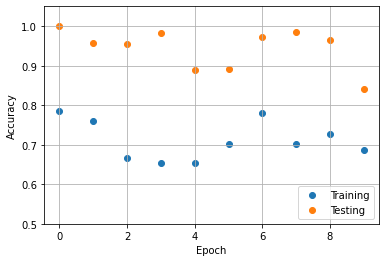

In [39]:
fig, ax = plt.subplots()
ax.scatter(epoch, accuracy, label='Training')
ax.scatter(epoch, val_accuracy, label = 'Testing')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1.05])
ax.legend(loc='lower right')
ax.grid(True)

It seems the accuracy did not improve over the epochs

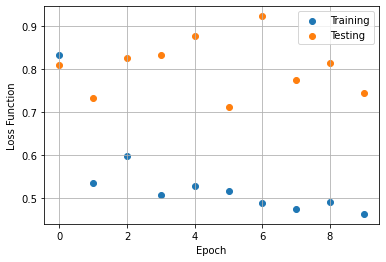

In [41]:
loss, val_loss = history_dict['loss'], history_dict['val_loss']
fig2, ax2 = plt.subplots()
ax2.scatter(epoch, loss, label='Training')
ax2.scatter(epoch, val_loss, label = 'Testing')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss Function')
ax2.legend(loc='upper right')
ax2.grid(True)

But it seems that the loss function was decreasing, which suggests that there could be room for improvement.